In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import os
os.chdir('/home/vaschetti/maxarSrc/src')
import sys
from torch.utils.data import DataLoader
from torchgeo.datasets import stack_samples, unbind_samples
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import cv2
import supervision as sv
import torch
from time import time
from random import randint

from my_functions.samplers_utils import boundingBox_2_Polygon
from my_functions.geoDatasets import Maxar
from my_functions.samplers import MyGridGeoSampler
from my_functions.segment import building_gdf, rel_bbox_coords, rel_polyg_coord

In [2]:
dataset = Maxar('/mnt/data2/vaschetti_data/maxar/Gambia-flooding-8-11-2022/pre/10300100CFC9A500/033133031213.tif')
size = 608
sampler = MyGridGeoSampler(dataset, size=size, stride=size)
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)
data_crs = dataset.crs

root = '/home/vaschetti/maxarSrc'

gdfs_32628 = building_gdf('TheGambia', os.path.join(root, 'metadata/buildings_dataset_links.csv'),  dataset_crs = data_crs)
index_MS_buildings = gdfs_32628.sindex

Found 6 links for TheGambia


In sampler
tile_polygon:  POLYGON ((320156.25 1489843.75, 315455.322265625 1489843.75, 315470.63516642543 1492342.8892077415, 320156.25 1491748.5059546148, 320156.25 1489843.75))
In plot
Crs EPSG:32628
sx_low:  (317998.046875, 1489843.75)
dx_high:  (318183.59375, 1490029.296875)


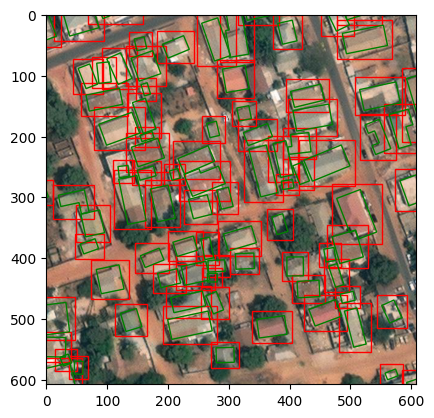

In [3]:
dataset_res = dataset.res
i = 0
for batch in dataloader:
    query_bbox_poly = boundingBox_2_Polygon(batch['bbox'][0])
    hits = index_MS_buildings.query(query_bbox_poly)
    if len(hits) > 10: #per prendere immagini con almeno X edifici
        i+=1
        if i == 10 :#randint(0, 20): #per prendere immagini random
            sample = unbind_samples(batch)[0]
            img4Sam = sample["image"].permute(1, 2, 0).numpy().astype('uint8')
            
            #predictor.set_image(img4Sam) #encoding the image

            #Getting the relative coordinates of the buildings boxes
            building_boxes = rel_bbox_coords(gdfs_32628.iloc[hits], query_bbox_poly.bounds, dataset_res, ext_mt=5)

            #Plotting
            fig, ax = dataset.plot(sample)   
            for box in building_boxes:
                x0, y0 = box[0], box[1]
                w, h = box[2] - box[0], box[3] - box[1]
                rect = patches.Rectangle((x0, y0), w, h, linewidth=1, edgecolor='r', facecolor='none')            
                ax.add_patch(rect)
            for rel_pol in rel_polyg_coord(gdfs_32628.iloc[hits], query_bbox_poly.bounds, dataset_res):
                poly = patches.Polygon(rel_pol, linewidth=1, edgecolor='g', facecolor='none')
                ax.add_patch(poly)

            break

In [4]:
sys.path.append('/home/vaschetti/maxarSrc/models/EfficientSAM')
from efficient_sam.build_efficient_sam import build_efficient_sam_vitt
from PIL import Image
from torchvision import transforms
import torch
import numpy as np
import matplotlib.pyplot as plt

In [11]:
# Build the model.
device = 'cuda:2'
ESAM_root = '/home/vaschetti/maxarSrc/models/EfficientSAM'
efficient_sam = build_efficient_sam_vitt(os.path.join(ESAM_root, 'weights/efficient_sam_vitt.pt')).to(device)

In [12]:
# load an image
sample_image_np = img4Sam
sample_image_tensor = transforms.ToTensor()(sample_image_np)
sample_image_tensor = sample_image_tensor.to(device)

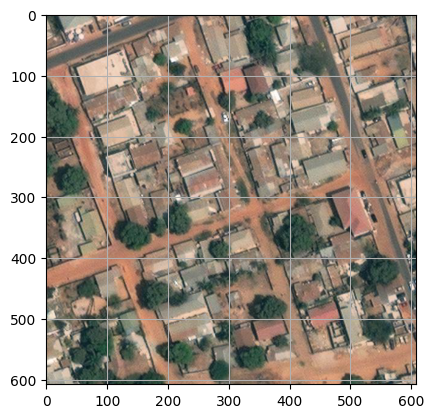

In [13]:
plt.imshow(sample_image_np)
plt.grid(True)
plt.show()

In [14]:
t_build_boxes = torch.tensor(building_boxes, device=device)
print('building boxes:', t_build_boxes.shape)
ESAM_boxes = t_build_boxes.unsqueeze(0)
ESAM_boxes = ESAM_boxes.reshape(-1,2,2)
print('ESAM_boxes:', ESAM_boxes.shape)

building boxes: torch.Size([86, 4])
ESAM_boxes: torch.Size([86, 2, 2])


In [15]:
input_points = ESAM_boxes.unsqueeze(0) #[B, max_num_queries, num_pts, 2] = [B, #boxes, 2, 2] unsqueeze to add the batch dim
input_labels = torch.tensor([[[2,3]]*input_points.shape[1]], device=device) #[B, max_num_queries, num_pts]

print(input_points.shape)
print(input_labels.shape)

torch.Size([1, 86, 2, 2])
torch.Size([1, 86, 2])


In [16]:
t0 = time()
predicted_logits, predicted_iou = efficient_sam(
    sample_image_tensor[None, ...],
    input_points[:,:3], #here we use only the first box
    input_labels[:,:3],
)
print('Time:', time() - t0)

Time: 0.20530462265014648


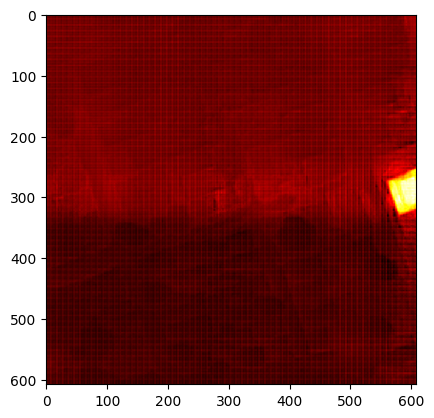

In [17]:
import matplotlib.pyplot as plt

# Assuming 'tensor' is your tensor
tensor_np = predicted_logits[0,1,0].cpu().detach().numpy()

plt.imshow(tensor_np, cmap='hot', interpolation='nearest')
plt.show()

Mask: torch.Size([1, 3, 3, 608, 608])


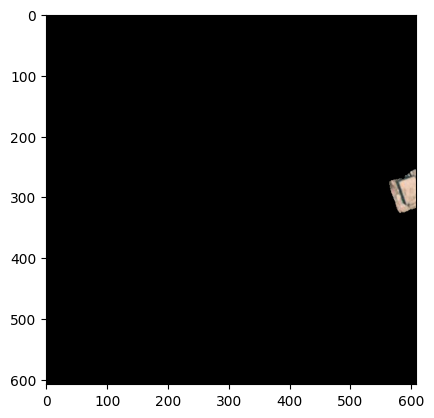

In [18]:
# The masks are already sorted by their predicted IOUs.
# The first dimension is the batch size (we have a single image. so it is 1).
# The second dimension is the number of masks we want to generate (in this case, it is only 1)
# The third dimension is the number of candidate masks output by the model.
# For this demo we use the first mask.

mask_ix = 1 #here we use the second mask
mask = torch.ge(predicted_logits[0, mask_ix, 0, :, :], 0).cpu().detach().numpy()

masked_image_np = sample_image_np.copy().astype(np.uint8) * mask[:,:,None]

print('Mask:', predicted_logits.shape)
plt.imshow(masked_image_np)
#Image.fromarray(masked_image_np).save("figs/examples/dogs_efficient_sam_mask.png")

Mask: torch.Size([1, 3, 3, 608, 608])


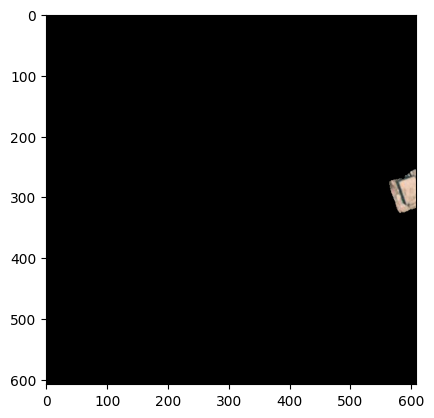

In [19]:
# The masks are already sorted by their predicted IOUs.
# The first dimension is the batch size (we have a single image. so it is 1).
# The second dimension is the number of masks we want to generate (in this case, it is only 1)
# The third dimension is the number of candidate masks output by the model.
# For this demo we use the first mask.
masked_image_np = sample_image_np.copy().astype(np.uint8) * mask[:,:,None]

print('Mask:', predicted_logits.shape)
plt.imshow(masked_image_np)

In [20]:
from my_functions.plotting_utils import show_mask
    
def plot_w_wo_masks_ESAM(img, masks, building_boxes = None):
    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(img)

    ax2 = fig.add_subplot(1, 2, 2, sharex=ax1, sharey=ax1)
    ax2.imshow(img)
    if masks.ndim == 2:
        masks = masks[np.newaxis, ...]
    for mask in masks:
        show_mask(mask, ax2)
    if building_boxes is not None:
        for box in building_boxes:
            x0, y0 = box[0], box[1]
            w, h = box[2] - box[0], box[3] - box[1]
            rect = patches.Rectangle((x0, y0), w, h, linewidth=1, edgecolor='r', facecolor='none')            
            ax2.add_patch(rect)
    
    ax2.set_xlim([0, img.shape[1]])
    ax2.set_ylim([img.shape[0], 0])

    ax1.axis('off')
    ax2.axis('off')

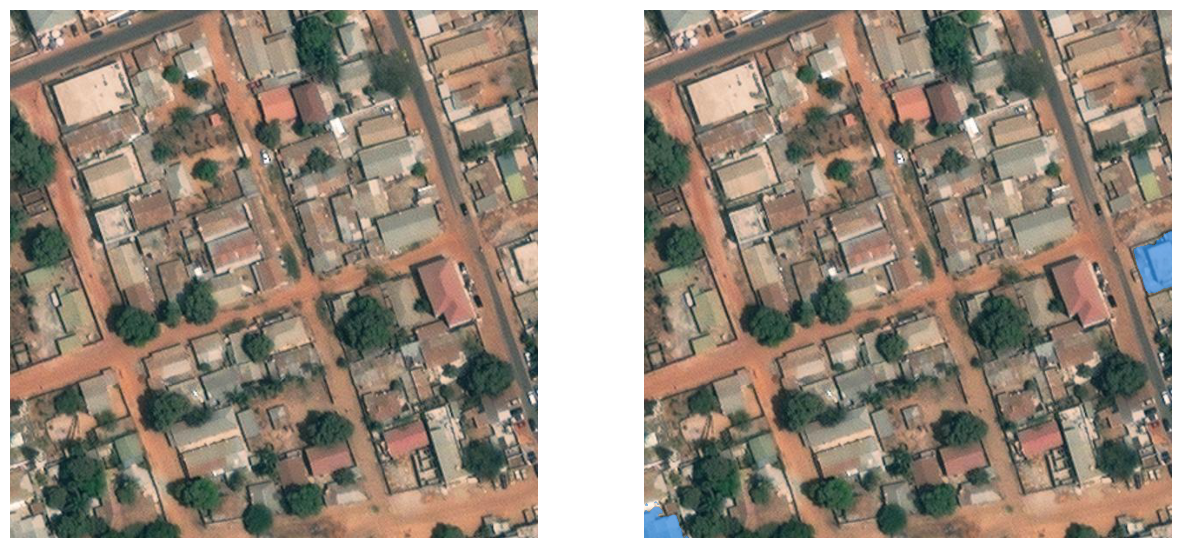

In [21]:
mask = torch.ge(predicted_logits[0, :, 0], 0).cpu().detach().numpy().any(axis=0)
plot_w_wo_masks_ESAM(sample_image_np, mask)

In [22]:
mask = torch.ge(predicted_logits[0, mask_ix, 0, :, :], 0).cpu().detach().numpy()

In [23]:
predicted_logits.shape

torch.Size([1, 3, 3, 608, 608])

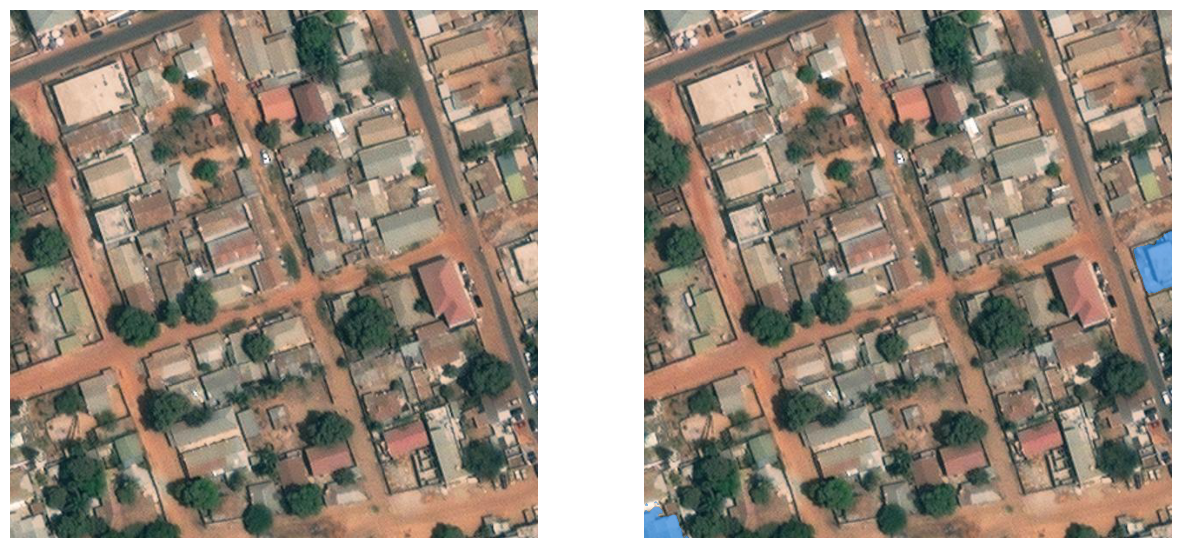

In [24]:
mask = torch.ge(predicted_logits[0, :, 0], 0).cpu().detach().numpy().any(axis=0)
plot_w_wo_masks_ESAM(sample_image_np, mask)